In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

In [0]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [0]:
!mkdir data

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [0]:
download() 

In [9]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [12]:
print(len(x_train))

320000


cookie


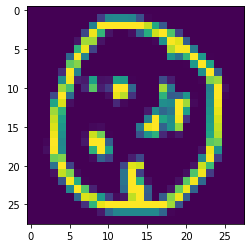

In [13]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 
# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

In [16]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Train on 288000 samples, validate on 32000 samples
Epoch 1/5
288000/288000 - 290s - loss: 1.9844 - top_k_categorical_accuracy: 0.7709 - val_loss: 1.3906 - val_top_k_categorical_accuracy: 0.8782
Epoch 2/5
288000/288000 - 296s - loss: 1.2550 - top_k_categorical_accuracy: 0.8917 - val_loss: 1.1723 - val_top_k_categorical_accuracy: 0.9016
Epoch 3/5
288000/288000 - 270s - loss: 1.0907 - top_k_categorical_accuracy: 0.9096 - val_loss: 1.0561 - val_top_k_categorical_accuracy: 0.9152
Epoch 4/5
288000/288000 - 280s - loss: 1.0022 - top_k_categorical_accuracy: 0.9188 - val_loss: 1.0097 - val_top_k_categorical_accuracy: 0.9181
Epoch 5/5
288000/288000 - 271s - loss: 0.9397 - top_k_categorical_accuracy: 0.9250 - val_loss: 0.9650 - val_top_k_categorical_accuracy: 0.9225


In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 92.05%


['lollipop', 'stop_sign', 'spoon', 'frying_pan', 'umbrella']


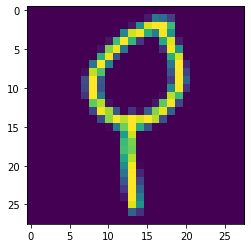

In [18]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [0]:
!pip install tensorflowjs 

In [0]:
model.save('keras.h5')

In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

In [0]:
!cp class_names.txt model/class_names.txt

In [25]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/group1-shard1of1.bin (deflated 7%)
  adding: model/model.json (deflated 85%)
  adding: model/class_names.txt (deflated 41%)


In [0]:
from google.colab import files
files.download('/content/model.zip')